In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# loading clean data

In [3]:
import os
clean_files = ['../data/cleaned_data/all_dataset.parquet']

In [4]:
dfs = []
for file in clean_files:
    dfs.append(pd.read_parquet(file))
df = pd.concat(dfs, axis = 0)

In [5]:
df.index = pd.to_datetime(df.index)

In [6]:
df['state_of_charge_percent'] = df['state_of_charge_percent'].clip(0,120)

In [7]:
all_ids = df.battery_id.unique()

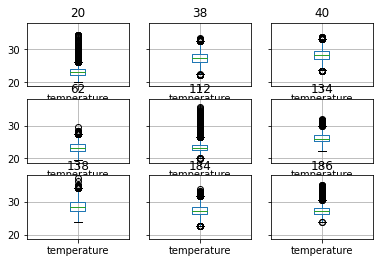

In [8]:
n = 10
random_ids = np.random.choice(all_ids, n)

sub_df = df[df['battery_id'].isin(random_ids)]

sub_df[['battery_id','temperature']].groupby('battery_id').boxplot(column = 'temperature');

In [9]:
medians = df.groupby(['battery_id','hour','minutes']).median()

In [10]:
d_stats = df.resample('1D')[['power_in','power_out','usb_power','state_of_charge_percent']].mean()

<AxesSubplot:xlabel='timestamp'>

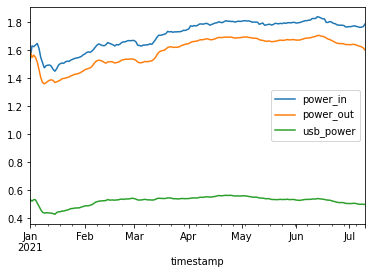

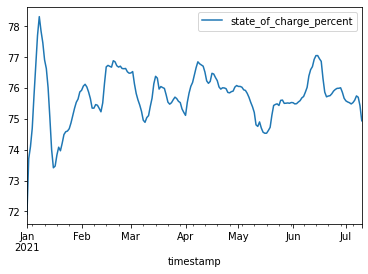

In [11]:
d_stats[['power_in','power_out','usb_power']].rolling('30D').mean().plot()
d_stats[['state_of_charge_percent']].rolling('30D').mean().plot()

<AxesSubplot:xlabel='timestamp'>

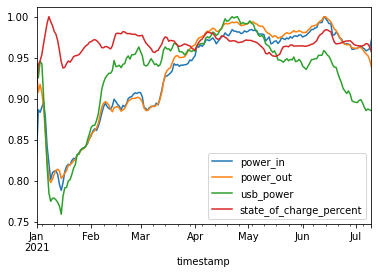

In [12]:
temp = d_stats.rolling('30D').mean()
temp /= temp.max()
temp.plot()

In [13]:
d_stats = df.groupby('battery_id').resample('1D')[['power_in','power_out','usb_power','state_of_charge_percent']].mean()

<AxesSubplot:xlabel='timestamp'>

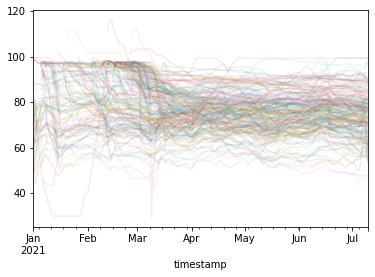

In [14]:
d_stats['state_of_charge_percent'].unstack(level = 0).rolling('30D').mean().plot(alpha = 0.1, legend = False)

<AxesSubplot:xlabel='timestamp'>

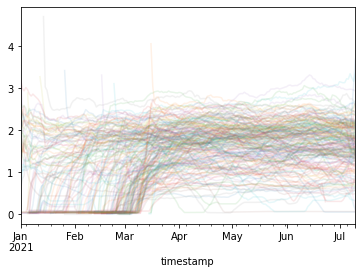

In [15]:
d_stats['power_out'].unstack(level = 0).rolling('30D').mean().plot(alpha = 0.1, legend = False)

<AxesSubplot:xlabel='timestamp'>

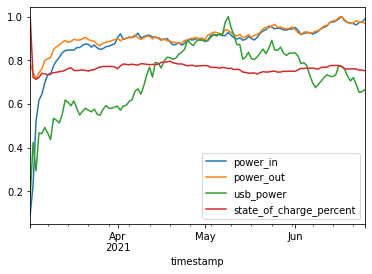

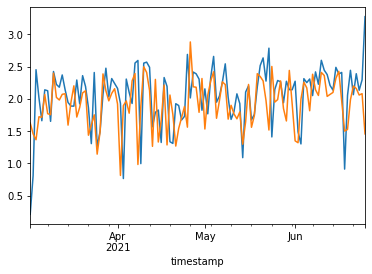

In [16]:
temp = d_stats.loc[0].rolling('30D').mean()
temp /= temp.max()
temp.plot()

plt.figure()
d_stats.loc[0]['power_in'].plot()
d_stats.loc[0]['power_out'].plot()

In [17]:
# why should we use medians = df.groupby(['battery_id','hour','minutes']).median()?

# compute mean power over a day, take median one, then choose this day as typical day

In [18]:
def get_median_index(d):
    ranks = d.rank(pct=True)
    close_to_median = abs(ranks - 0.5)
    return close_to_median.idxmin()[1]

In [19]:
median_day = d_stats.groupby('battery_id')['power_out'].apply(get_median_index)


In [20]:
df.head()

,battery_id,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,usb_current,voltage,...,usb_power,power_in,net_power_battery,other_out_current,bool_current_out,bool_current_in,hour,minutes,day_n,hour:min
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-03-02 06:40:00,0,7.0750,-2.276,2.278,0.002,7.350,100.0,28.287938,0.002,7.280,...,0.014150,16.116850,16.102700,0.000,0.0,1.0,6,40,1,6:40
2021-03-02 06:50:00,0,6.7200,0.000,0.002,0.002,0.005,102.0,27.152667,0.002,6.735,...,0.013440,0.013440,0.000000,0.000,0.0,0.0,6,50,1,6:50
2021-03-02 07:00:00,0,6.7100,0.010,0.002,0.012,0.005,102.0,26.919203,0.002,6.725,...,0.013420,0.013420,-0.067100,0.010,0.0,0.0,7,0,1,7:0
2021-03-02 07:10:00,0,6.7050,0.010,0.002,0.012,0.005,102.0,27.003891,0.002,6.720,...,0.013410,0.013410,-0.067050,0.010,0.0,0.0,7,10,1,7:10
2021-03-02 07:20:00,0,6.7025,0.013,0.002,0.015,0.005,102.0,27.096590,0.002,6.715,...,0.013405,0.013405,-0.087125,0.013,0.0,0.0,7,20,1,7:20


In [21]:
test = pd.merge(df, median_day.rename('median_day'), left_on= 'battery_id', right_index=True)

In [22]:
test['date'] = test.index.date

In [23]:
profiles = test[test['median_day'] == test['date']]

In [24]:
profiles = profiles.reset_index().set_index(['battery_id','hour','minutes']).sort_index()

<AxesSubplot:xlabel='hour,minutes'>

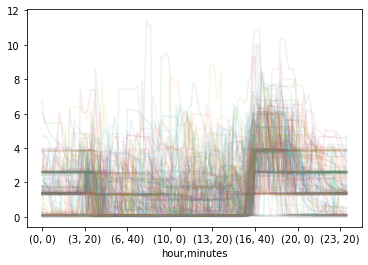

In [26]:
profiles['power_out'].unstack(level=0).plot(legend = False, alpha = 0.1)

<AxesSubplot:xlabel='hour,minutes'>

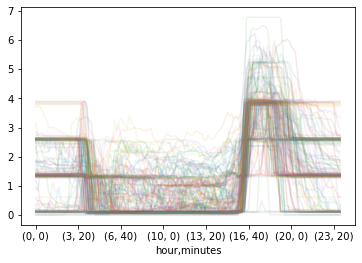

In [28]:
medians['power_out'].unstack(level = 0).sort_index().plot(alpha = 0.1, legend = False)

In [124]:
max_power = df['power_out'].quantile(0.99)
min_power = 0
df['binned_power'] = pd.cut(df['power_out'], np.linspace(min_power,max_power,10))
df_quants = df.groupby(['battery_id','binned_power'])['power_out'].count().unstack('binned_power')
df_quants = df_quants.div(df_quants.sum(axis = 1), axis = 0)

In [125]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_quants.values)
    distortions.append(kmeanModel.inertia_)

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


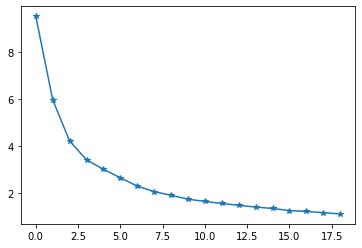

In [126]:
plt.plot(distortions, marker = '*')

In [127]:
n_clusters = 3
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
kmeanModel = KMeans(n_clusters=n_clusters)
y=kmeanModel.fit(df_quants.values).labels_
y_bin = label_binarize(y, classes=np.arange(0,n_clusters))
clf=RandomForestClassifier()
clf.fit(df_quants.values,y)

RandomForestClassifier()

plot 0


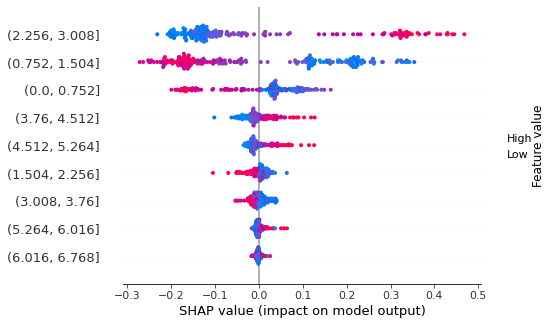

plot 1


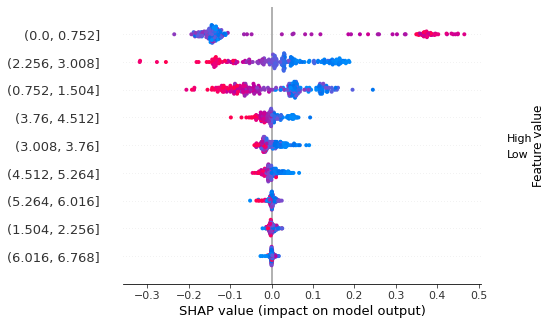

plot 2


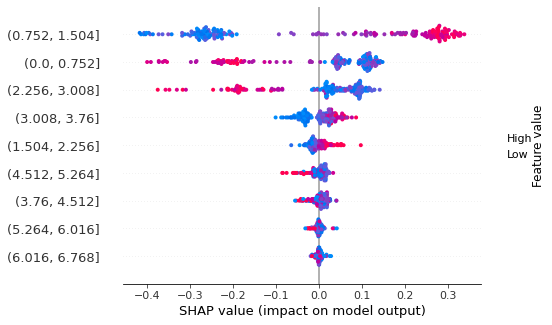

In [129]:
import shap

explainer= shap.TreeExplainer(clf)
shap_values = explainer(df_quants)
for k in range(n_clusters):
    print(f'plot {k}')
    shap.plots.beeswarm(shap_values[:,:,k])


In [130]:
id_to_class = pd.DataFrame(data = y, index = df_quants.index, columns = ['class']).squeeze().to_dict()

<AxesSubplot:xlabel='binned_power', ylabel='n_count'>

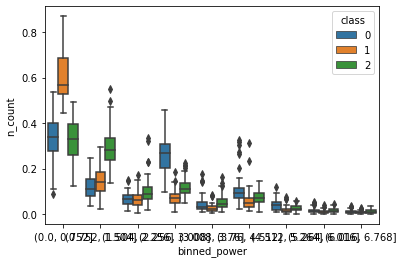

In [131]:
df_quants = df_quants.stack()
df_quants = df_quants.rename('n_count')
df_quants = df_quants.reset_index()
df_quants['class'] = df_quants['battery_id'].map(id_to_class)
sns.boxplot(data = df_quants, x = 'binned_power', y = 'n_count', hue = 'class')

# standardizing

see that again

Feature names only support names that are all strings. Got feature names with dtypes: ['Interval']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['Interval']. An error will be raised in 1.2.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


plot 0


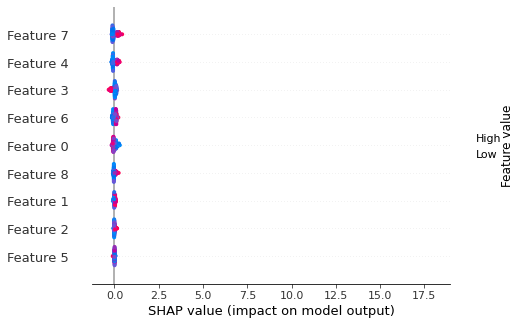

plot 1


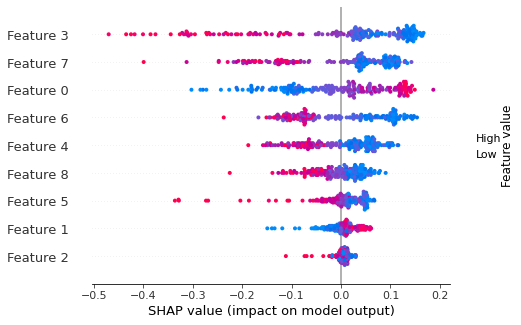

plot 2


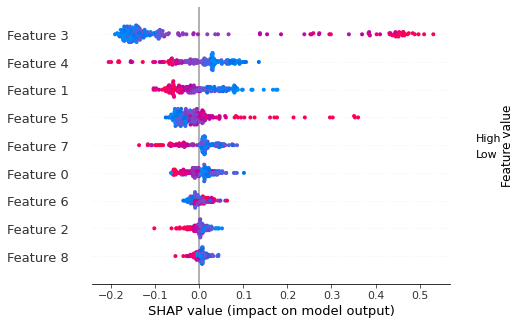

<AxesSubplot:xlabel='binned_power', ylabel='n_count'>

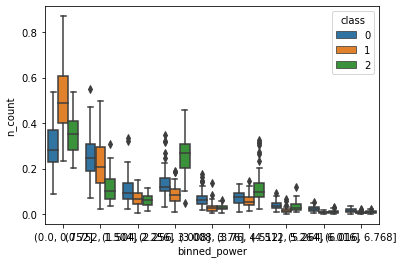

In [114]:
max_power = df['power_out'].quantile(0.99)
min_power = 0
df['binned_power'] = pd.cut(df['power_out'], np.linspace(min_power,max_power,10))
df_quants = df.groupby(['battery_id','binned_power'])['power_out'].count().unstack('binned_power')
df_quants = df_quants.div(df_quants.sum(axis = 1), axis = 0)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(df_quants)

from sklearn.cluster import KMeans
distortions = []

K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_std)
    distortions.append(kmeanModel.inertia_)
plt.plot(distortions, marker = '*')

n_clusters = 3
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
kmeanModel = KMeans(n_clusters=n_clusters)
y=kmeanModel.fit(X_std).labels_
y_bin = label_binarize(y, classes=np.arange(0,n_clusters))
clf=RandomForestClassifier()
clf.fit(X_std,y)
import shap

explainer= shap.TreeExplainer(clf)
shap_values = explainer(X_std)
for k in range(n_clusters):
    print(f'plot {k}')
    shap.plots.beeswarm(shap_values[:,:,k])

label_to_class = pd.DataFrame(data = y, index = df_quants.index, columns = ['class']).squeeze().to_dict()
df_quants = df_quants.stack()
df_quants = df_quants.rename('n_count')
df_quants = df_quants.reset_index()
df_quants['class'] = df_quants['battery_id'].map(label_to_class)
sns.boxplot(data = df_quants, x = 'binned_power', y = 'n_count', hue = 'class')

<AxesSubplot:xlabel='hour,minutes'>

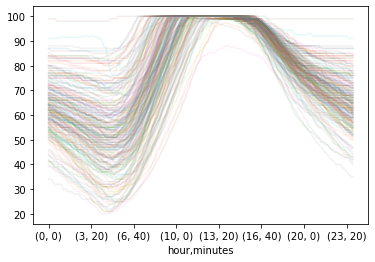

In [44]:
medians['state_of_charge_percent'].unstack(level = 0).sort_index().plot(alpha = 0.1, legend = False)

In [86]:
X = medians[['power_out']].unstack(level = [1,2])

In [88]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 8
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=10, n_init= 3)
power_out_shape = X
classes = model.fit_predict(power_out_shape)
power_out_shape['classes'] = classes
power_out_shape = power_out_shape.reset_index().set_index(['classes','battery_id'])

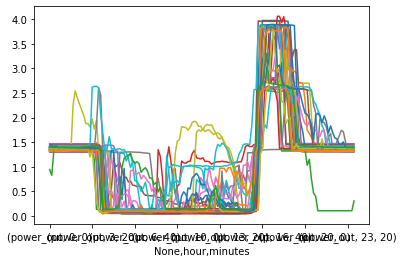

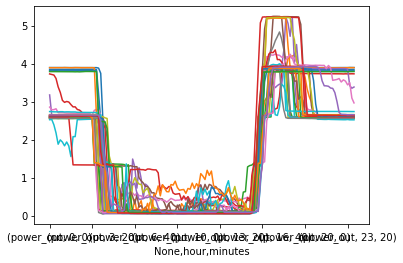

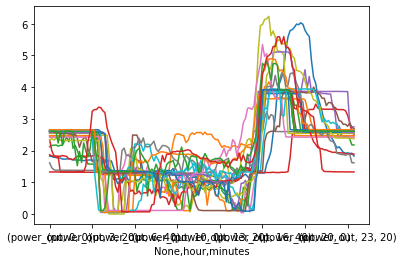

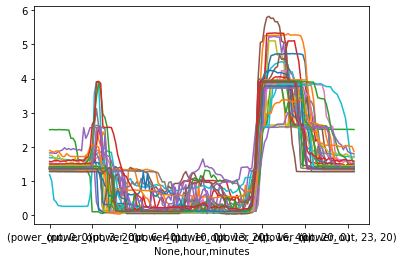

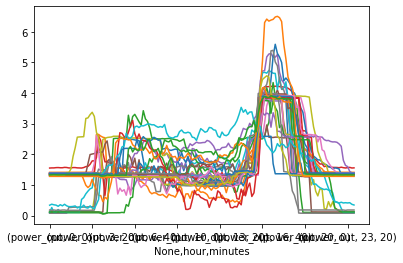

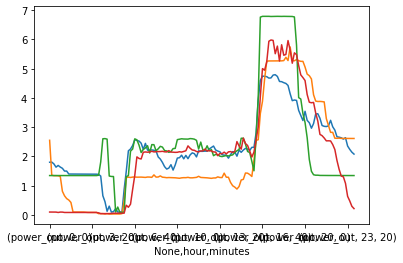

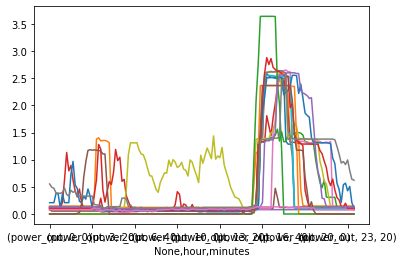

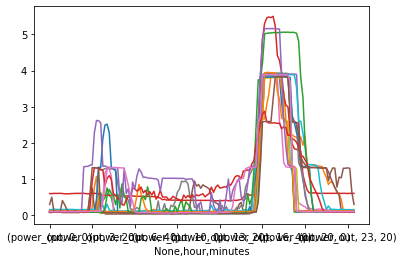

In [89]:
for k in range(n_clusters):
    df_plot = power_out_shape.loc[k].transpose()
    df_plot.plot(legend = False)

In [91]:
X = medians[['state_of_charge_percent']].unstack(level = [1,2])

In [92]:
import scipy.cluster.hierarchy as hac

Z = hac.linkage(X, method='ward', metric='euclidean')


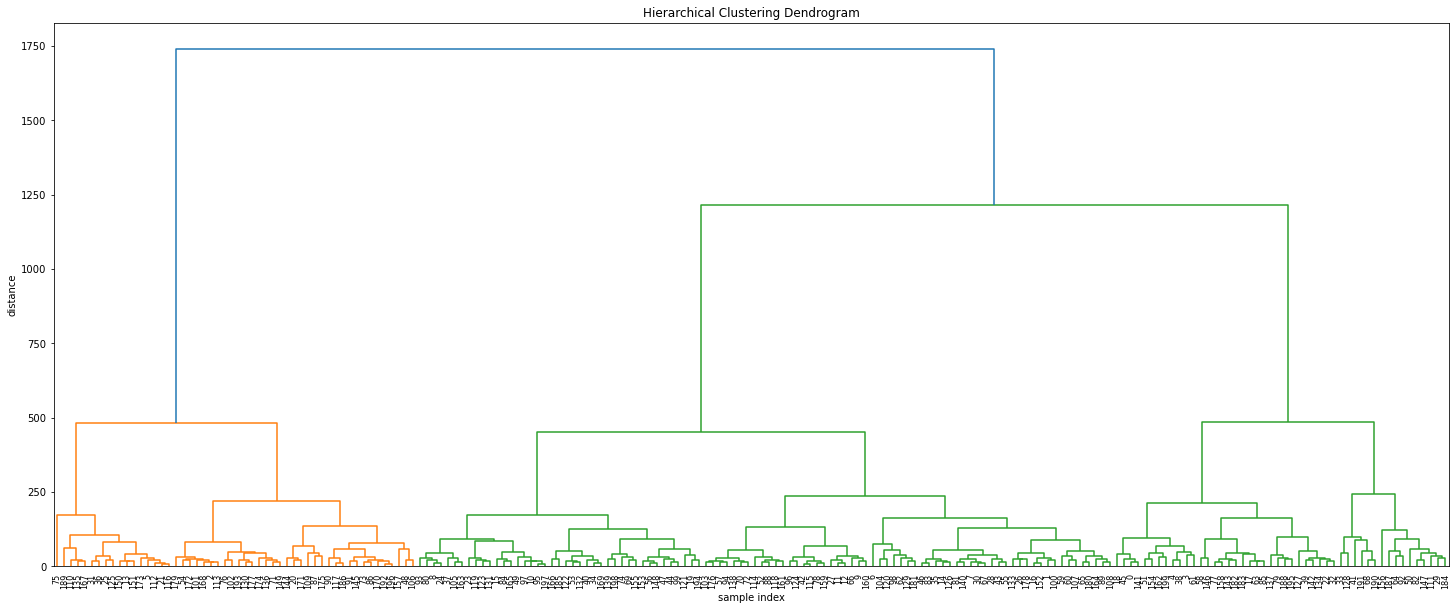

In [93]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [94]:
n_clusters = 6
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=10, n_init= 3)
power_out_shape = X
classes = model.fit_predict(power_out_shape)
power_out_shape['classes'] = classes
power_out_shape = power_out_shape.reset_index().set_index(['classes','battery_id'])

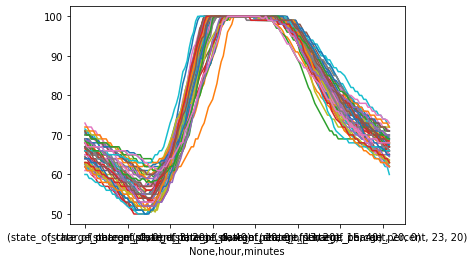

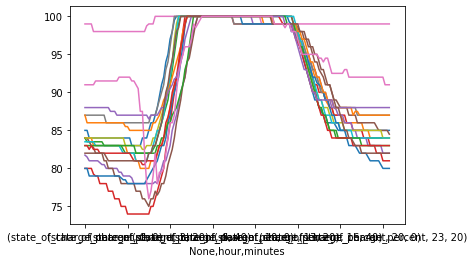

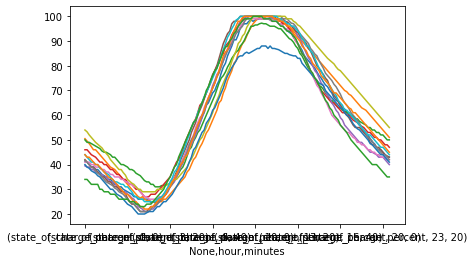

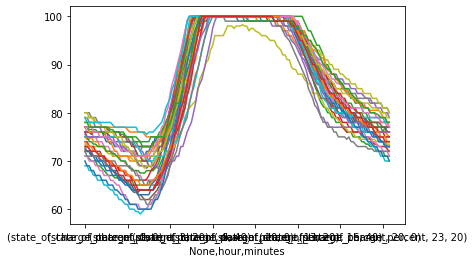

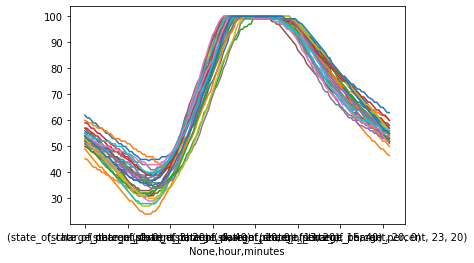

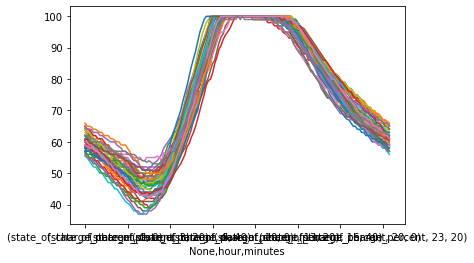

In [95]:
for k in range(n_clusters):
    df_plot = power_out_shape.loc[k].transpose()
    df_plot.plot(legend = False)

In [243]:
min_soc = 0
max_soc = 120
step = 20
df['binned_soc'] = pd.cut(df['state_of_charge_percent'], bins = np.arange(min_soc, max_soc+step,step))

In [244]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [245]:
features = df.groupby(['battery_id','binned_soc'])[['power_out','temperature']].agg(['median',percentile(1),percentile(99)])

In [247]:
features[[('count','count')]] = df.groupby(['battery_id','binned_soc'])[['power_out']].agg(['count'])

<AxesSubplot:xlabel='binned_soc'>

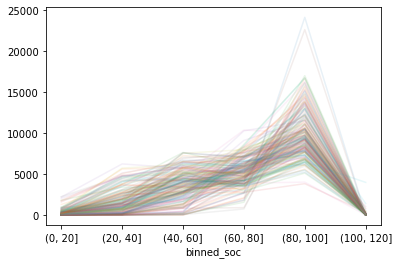

In [248]:
features['count'].unstack(level = 0).plot(y = 'count', alpha = 0.1, legend = False)

# PCA

In [249]:
features = features.groupby('binned_soc').apply(lambda x: x.fillna(x.mean()))

In [250]:
features = features.unstack(level = 1)

In [251]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(features)

C:\Users\PC_victor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

C:\Users\PC_victor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



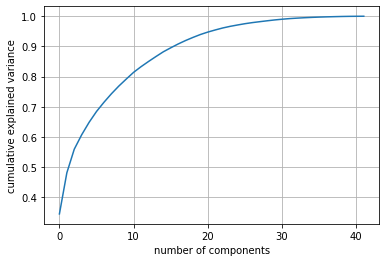

In [252]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_std)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.grid();

In [258]:
n_components = 3
two_comp_PCA = PCA(n_components=n_components)
X_pca = two_comp_PCA.fit_transform(X_std)

In [259]:
two_comp_PCA.explained_variance_ratio_

array([0.3451613 , 0.13608459, 0.0783223 ])

In [260]:
loadings = two_comp_PCA.components_.T * np.sqrt(two_comp_PCA.explained_variance_)


In [261]:
feature_names = features.columns.map('{0[0]}_{0[1]}_{0[2]}'.format) 

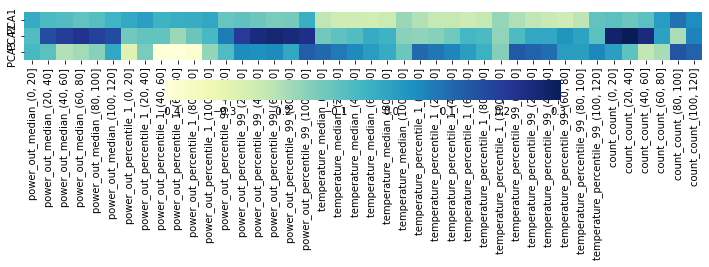

In [262]:
plt.figure(figsize = (10,4))
ax = sns.heatmap(two_comp_PCA.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,two_comp_PCA.n_components_+1)],
                 xticklabels=list(feature_names),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
plt.tight_layout()

In [236]:
import plotly.express as px


In [263]:
names_to_plot = []
for i, power in enumerate(np.sqrt(loadings[:,0]**2 + loadings[:,1]**2)):
    if power > 0.90:
        names_to_plot.append((i,feature_names[i]))

In [264]:
names_to_plot

[(19, 'temperature_median_(20, 40]'),
 (20, 'temperature_median_(40, 60]'),
 (21, 'temperature_median_(60, 80]'),
 (22, 'temperature_median_(80, 100]'),
 (25, 'temperature_percentile_1_(20, 40]'),
 (26, 'temperature_percentile_1_(40, 60]'),
 (27, 'temperature_percentile_1_(60, 80]'),
 (33, 'temperature_percentile_99_(60, 80]')]

In [265]:
fig = px.scatter(X_pca, x=0, y=1)

for i, feature in names_to_plot:
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    '''     fig.add_annotation(
            x=loadings[i, 0],
            y=loadings[i, 1],
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text=feature, '''
    #)
fig.show()

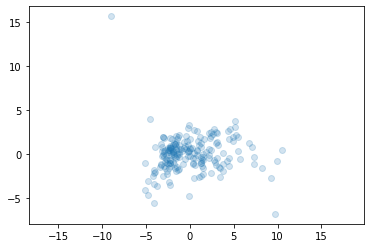

In [242]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
plt.axis('equal');

# Viz

<AxesSubplot:xlabel='day_n,hour,minutes'>

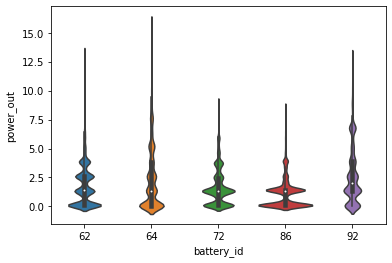

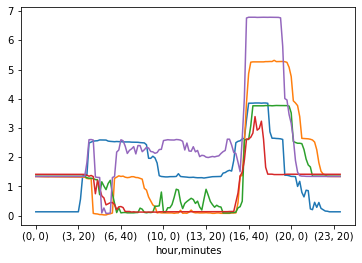

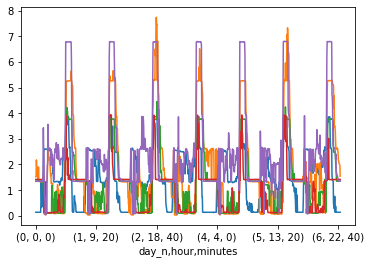

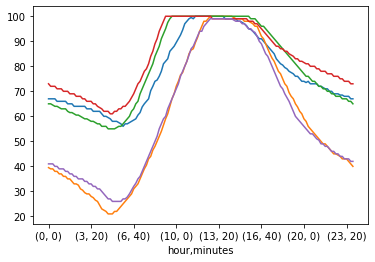

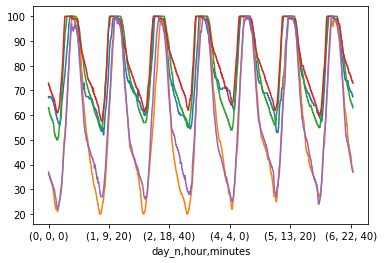

In [5]:
n = 5
randoms_ids = np.random.choice(df.battery_id.unique(), n)

subset = df[df['battery_id'].isin(randoms_ids)]

sns.violinplot(data = subset, x = 'battery_id', y="power_out")

weekly_median_profiles = subset.groupby(['battery_id','day_n','hour','minutes']).median()
daily_median_profiles = subset.groupby(['battery_id','hour','minutes']).median()

daily_median_profiles['power_out'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)
weekly_median_profiles['power_out'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

daily_median_profiles['state_of_charge_percent'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)
weekly_median_profiles['state_of_charge_percent'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

<AxesSubplot:xlabel='day_n,hour,minutes'>

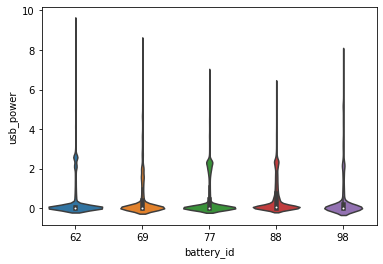

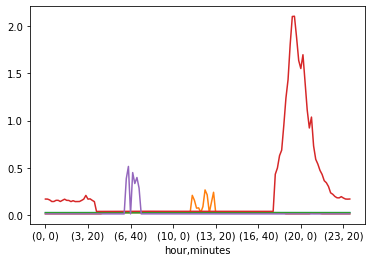

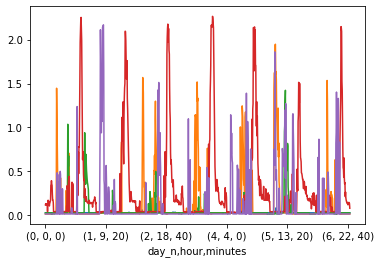

In [17]:
sns.violinplot(data = subset, x = 'battery_id', y="usb_power")

weekly_median_profiles = subset.groupby(['battery_id','day_n','hour','minutes']).median()
daily_median_profiles = subset.groupby(['battery_id','hour','minutes']).median()

daily_median_profiles['usb_power'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)
weekly_median_profiles['usb_power'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

<AxesSubplot:title={'center':'mean power_out per soc_bin'}, xlabel='binned_soc'>

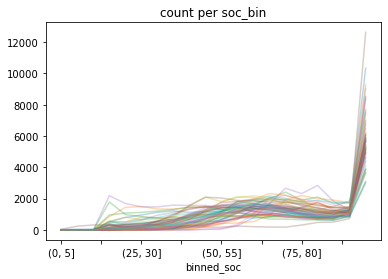

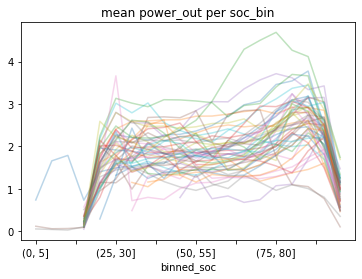

In [15]:
increment = 5
df['binned_soc'] = pd.cut(df['state_of_charge_percent'], np.arange(0,100+increment,increment))
count = df.groupby(['battery_id','binned_soc'])['state_of_charge_percent'].count()
binned_soc = df.groupby(['battery_id','binned_soc']).mean()
binned_soc['count'] = count

binned_soc['count'].unstack(level = 0).plot(legend = False, alpha = 0.3, title = 'count per soc_bin')
binned_soc['power_out'].unstack(level = 0).plot(legend = False, alpha = 0.3, title = 'mean power_out per soc_bin')

In [18]:
df = df.reset_index().set_index(['timestamp','battery_id'])
df = df.sort_index()

In [19]:
df['observed_mileage'] = df.groupby('battery_id')['power_out'].transform('cumsum')

<AxesSubplot:title={'center':'mileage (cumulative sum of output power)'}, xlabel='timestamp'>

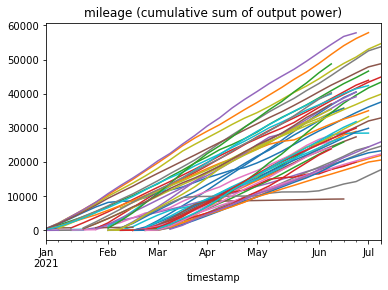

In [22]:
df['observed_mileage'].unstack(level = 1).resample('1W').mean().plot(legend = False, title = 'mileage (cumulative sum of output power)')

# little fun

In [26]:
print(df.index.min(), df.index.max())

2021-01-01 00:00:00 2021-07-10 04:40:00


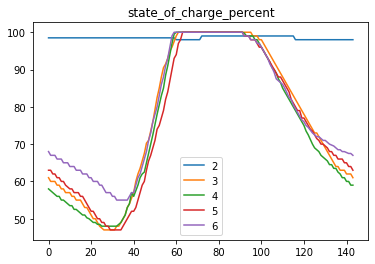

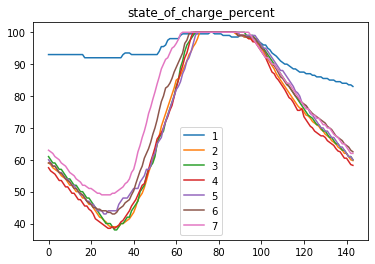

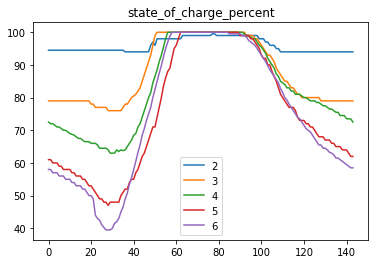

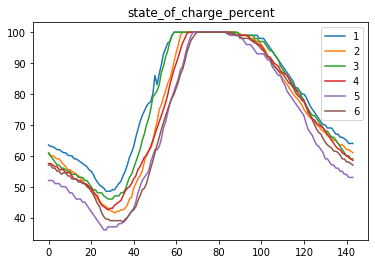

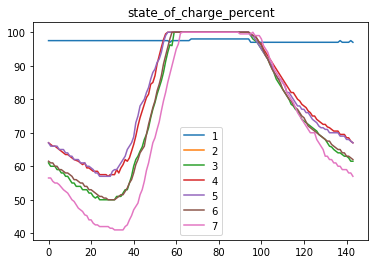

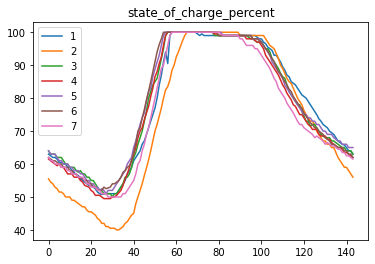

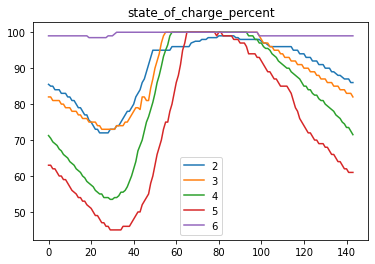

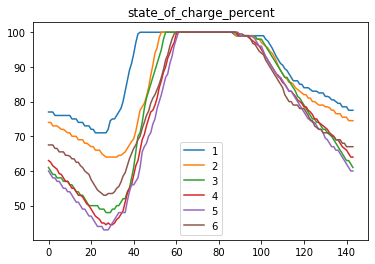

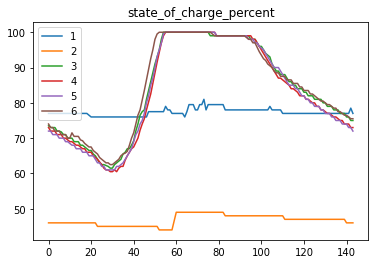

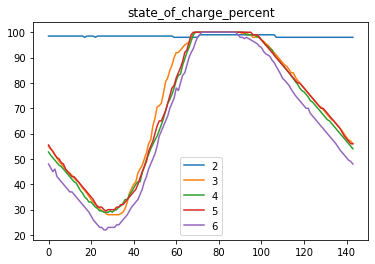

In [25]:
df = df.reset_index().set_index('timestamp')

n = 10
randoms_ids = np.random.choice(df.battery_id.unique(), n)

for bat_id in randoms_ids:
    subset = df[df['battery_id'] == bat_id].copy()
    subset['month'] = subset.index.month
    months = subset.month.unique()
    months.sort()

    '''     plt.figure()
    plt.title('power_out')
    for mo in months:
        subset_month = subset[subset['month'] == mo]
        daily_median_profiles = subset_month.groupby(['battery_id','hour','minutes']).median()
        plt.plot(daily_median_profiles['power_out'].values, label = mo)
        plt.legend() '''

    plt.figure()
    plt.title('state_of_charge_percent')
    for mo in months:
        subset_month = subset[subset['month'] == mo]
        daily_median_profiles = subset_month.groupby(['battery_id','hour','minutes']).median()
        plt.plot(daily_median_profiles['state_of_charge_percent'].values, label = mo)
        plt.legend()

# legacy

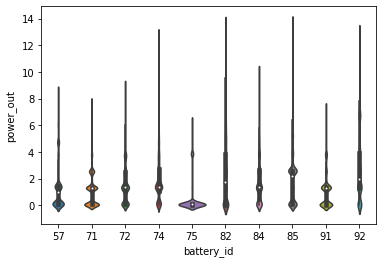

In [31]:
n = 10
randoms_ids = np.random.choice(df.battery_id.unique(), n)

subset = df[df['battery_id'].isin(randoms_ids)]

sns.violinplot(data = subset, x = 'battery_id', y="power_out")

weekly_median_profiles = subset.groupby(['battery_id','day_n','hour','minutes']).median()
daily_median_profiles = subset.groupby(['battery_id','hour','minutes']).median()

<AxesSubplot:xlabel='hour,minutes'>

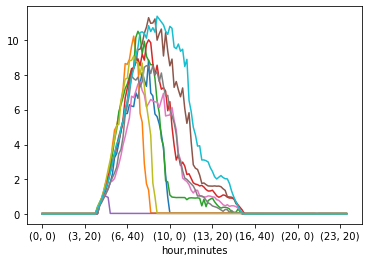

<Figure size 432x288 with 0 Axes>

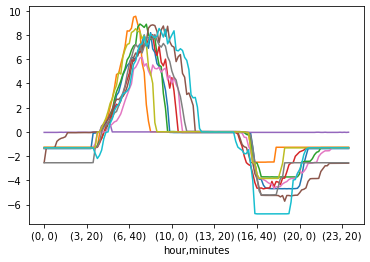

<Figure size 432x288 with 0 Axes>

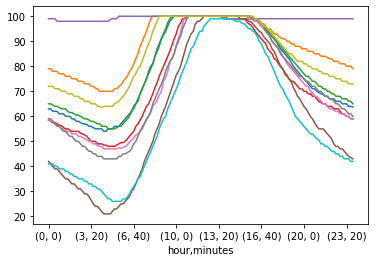

In [38]:
daily_median_profiles['power_in'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

plt.figure()

daily_median_profiles['net_power_battery'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

plt.figure()

daily_median_profiles['state_of_charge_percent'].unstack(level = 0).sort_index().plot(subplots = False, legend = False)

<AxesSubplot:>

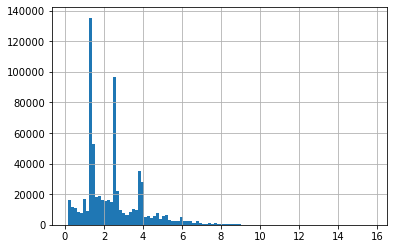

In [43]:
df[df['current_out'] > 2e-2].power_out.hist(bins = 100)

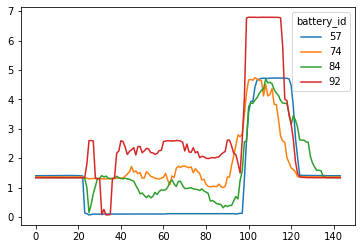

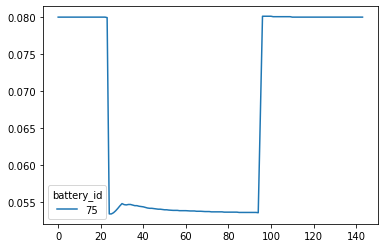

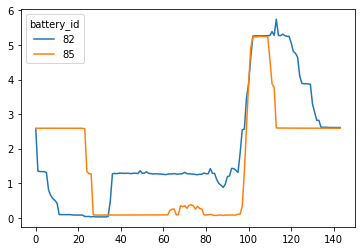

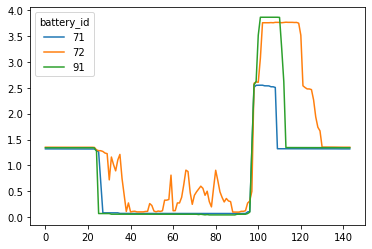

In [44]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 4
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10)
power_out_shape = daily_median_profiles['power_out'].unstack(level = 0).sort_index().reset_index(drop=True).transpose()
classes = model.fit_predict(power_out_shape)
power_out_shape['classes'] = classes
power_out_shape = power_out_shape.reset_index().set_index(['classes','battery_id'])
for k in range(n_clusters):
    df_plot = power_out_shape.loc[k].transpose()
    df_plot.plot()

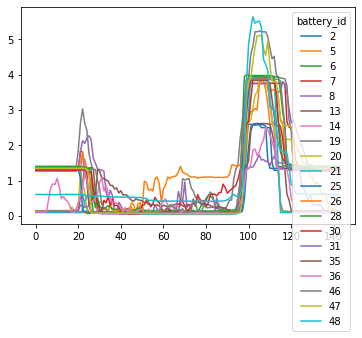

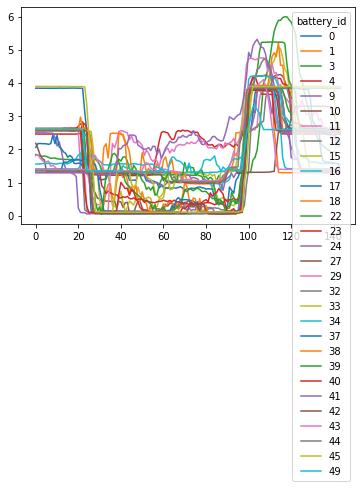

In [ ]:
n_clusters = 2
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=10)
power_out_shape = median_profiles['power_out'].unstack(level = 0).sort_index().reset_index(drop=True).transpose()
classes = model.fit_predict(power_out_shape)
power_out_shape['classes'] = classes
power_out_shape = power_out_shape.reset_index().set_index(['classes','battery_id'])
for k in range(n_clusters):
    df_plot = power_out_shape.loc[k].transpose()
    df_plot.plot()

In [ ]:
df_charging = df[df['current'] < -2e-1]

In [ ]:
import seaborn as sns

<AxesSubplot:xlabel='battery_id', ylabel='current_in'>

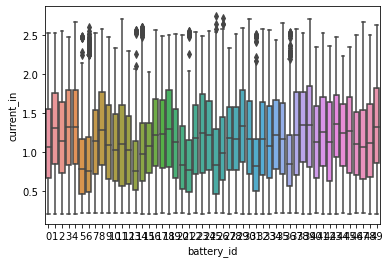

In [ ]:
sns.boxplot(data = df_charging, x = 'battery_id', y = 'current_in')